# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [3]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [4]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [5]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [6]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [7]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [8]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [9]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [11]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [12]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [13]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [14]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [15]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [16]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [17]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

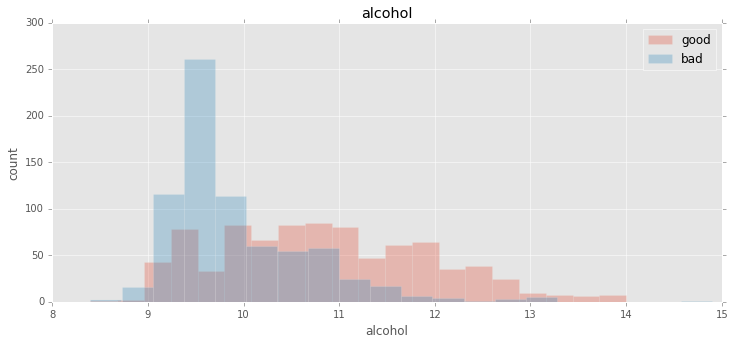

In [18]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [19]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [4]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

NameError: name 'X' is not defined

Получаем предсказание модели (на обучающей выборке)

In [5]:
y_hat = model.predict(X)

NameError: name 'X' is not defined

Оценим долю ошибок на обучающей выборке

In [6]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

NameError: name 'y_hat' is not defined

## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [7]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

NameError: name 'prepocess_wine' is not defined

In [ ]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [ ]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [509]:
from sklearn.base import ClusterMixin
import random
from collections import Counter

class KMeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.init = init
        self.max_iter = max_iter
        if random_state != None:
            np.random.seed(random_state)
        else:
            np.random.seed(10)
            
    def initialize_centroids(self, X):
        """
        Процедура инициализации начальных значений центроидов
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        #epsilon
        self.eps = 0.001
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros(X.shape[0])
        
        # Массив с центроидами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        # Делаем случайные центры (k-means)
        if self.init == 'random':
            idxs = random.sample(xrange(X.shape[0]), self.k)
            self.centroids = np.array([X[idxs[i],] for i in xrange(self.k)])
                
        # k-means++
        elif self.init == 'k-means':            
            self.centroids[0] = X[np.random.randint(0, self.k),]
            
            for centroids_num in xrange(1, self.k):
                prob =[]
                cum_prob = []
                for point in xrange(X.shape[0]):
                    dist = [((self.centroids[i] - X[point, ]) ** 2).sum() for i in xrange(centroids_num)]
                    
                    prob += [min(dist)]
                    cum_prob += [np.array(prob).sum()]
                    
                all_prob = np.array(prob).sum()
                all_prob *= np.random.random_sample()
                
                for prob in cum_prob:
                    if prob > all_prob:
                        self.centroids[centroids_num] = X[cum_prob.index(prob),]
                        break
            

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        self.initialize_centroids(X)
        
        # k-means
        iter_num = 0
        while iter_num < self.max_iter:
            fixed_number = 0
            
            # Делим все на кластеры
            for point in xrange(X.shape[0]):
                dist = [np.sqrt((self.centroids[i] - X[point, ]) ** 2).sum() for i in xrange(self.k)]
                self.labels[point] = np.argmin(dist)
        
            # Пересчитываем центры
            cnt = Counter(self.labels)
    
            for clast in xrange(self.k):
                sum_coord = np.zeros(X.shape[1])
                
                for point in xrange(X.shape[0]):
                    if (self.labels[point] == clast):
                        sum_coord += X[point, ]

                new_centroid = sum_coord / [cnt[clast] for i in xrange(X.shape[1])]
                
                # Насколько сдвинется центроид
                if (np.abs(new_centroid - self.centroids[clast]) < self.eps).all():
                    fixed_number += 1 
                
                self.centroids[clast] = new_centroid
        
            iter_num += 1
            if fixed_number == self.k:
                #print iter_num        
                return self
            
        #print iter_num        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return self.labels, self.centroids

class MiniBatchKMeans(KMeans):
    def __init__(self, k=2, batch_size=10000, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :batch_size - количество
        """
        super(MiniBatchKMeans, self).__init__(k, metric, max_iter, random_state, init)
        self.batch_size = batch_size
    
    
    def fit(self, X, y=None):
        """
        Процедура обучения mini-batch k-means 
        """
        
        self.initialize_centroids(X)
        iter_num = 0
        
        if self.batch_size > X.shape[0]:
            self.batch_size = X.shape[0] // 10
            
        print(self.batch_size)
        
        while iter_num < self.max_iter:
            
            # Выделяем новую выборку
            idxs = random.sample(xrange(X.shape[0]), self.batch_size)
            batches = np.array([X[idxs[i],] for i in xrange(self.batch_size)])
            
            batch_labels = np.empty(self.batch_size)
            
            counts_per_centroid = np.zeros(self.k)
            new_centroids = np.empty((self.k, X.shape[1]))
            
            # Считаем ближайший кластер для каждой точки в выборке
            for point in xrange(self.batch_size):
                dist = [np.sqrt((self.centroids[i] - batches[point, ]) ** 2).sum() for i in xrange(self.k)]
                batch_labels[point] = np.argmin(dist)
                
                
            # Шаг градиента
            for point in xrange(self.batch_size):
                curr_claster = int(batch_labels[point])
                counts_per_centroid[curr_claster] += 1
                
                learning_rate = 1 / counts_per_centroid[curr_claster]
                
                a = np.array([(1 - learning_rate) for i in xrange(X.shape[1])])
                new_centroids[curr_claster] = a * self.centroids[curr_claster] 
                b = np.array([learning_rate for i in xrange(X.shape[1])])
                new_centroids[curr_claster] += b * batches[point]
                
            fixed_number = 0
            print(self.centroids)
            print(new_centroids)
            print('=' * 10)
            for clast in xrange(self.k):
                print(np.abs(new_centroids[clast] - self.centroids[clast]))
                if (np.abs(new_centroids[clast] - self.centroids[clast]) < self.eps).any():
                    fixed_number += 1 
            print(fixed_number)
            if fixed_number == self.k:
                print iter_num
                return self
                
            
            # Распределяем точки по кластерам
            self.centroids = new_centroids  
            for point in xrange(X.shape[0]):
                dist = [np.sqrt((self.centroids[i] - X[point, ]) ** 2).sum() for i in xrange(self.k)]
                self.labels[point] = np.argmin(dist)
                
            
                
        
            iter_num += 1
        print iter_num
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [510]:
from sklearn.datasets import make_blobs

In [511]:
X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

50
[[ 6.63223938 -6.28795169]
 [-5.49405691  0.62514819]
 [-0.93243209  6.57369239]]
[[ 6.65169905 -6.19254375]
 [-5.5421346   0.71177417]
 [-1.07431082  6.51759552]]
[ 0.01945967  0.09540794]
[ 0.04807769  0.08662598]
[ 0.14187873  0.05609686]
0
[[ 6.65169905 -6.19254375]
 [-5.5421346   0.71177417]
 [-1.07431082  6.51759552]]
[[ 6.50685212 -6.07969975]
 [-5.49877948  0.72324266]
 [-1.05022443  6.48475713]]
[ 0.14484693  0.112844  ]
[ 0.04335511  0.01146848]
[ 0.02408639  0.03283839]
0
[[ 6.50685212 -6.07969975]
 [-5.49877948  0.72324266]
 [-1.05022443  6.48475713]]
[[ 6.46086877 -5.92255164]
 [-5.63261181  0.81609277]
 [-1.05839887  6.41628975]]
[ 0.04598335  0.15714811]
[ 0.13383233  0.09285011]
[ 0.00817444  0.06846738]
0
[[ 6.46086877 -5.92255164]
 [-5.63261181  0.81609277]
 [-1.05839887  6.41628975]]
[[ 6.49600049 -5.78548984]
 [-5.60338819  0.77054153]
 [-1.06618405  6.35108272]]
[ 0.03513172  0.13706181]
[ 0.02922362  0.04555123]
[ 0.00778518  0.06520703]
0
[[ 6.49600049 -5.7854

[ 0.04917605  0.00647479]
[ 0.06525069  0.08029576]
[ 0.00500713  0.02659559]
0
[[ 5.79749729 -5.01323154]
 [-5.95771452  2.26029778]
 [-1.39816754  5.5820982 ]]
[[ 5.77876141 -5.01315229]
 [-5.99183789  2.27179753]
 [-1.38460755  5.54093235]]
[  1.87358828e-02   7.92498578e-05]
[ 0.03412336  0.01149975]
[ 0.01355999  0.04116585]
1
[[ 5.77876141 -5.01315229]
 [-5.99183789  2.27179753]
 [-1.38460755  5.54093235]]
[[ 5.80774991 -4.99238756]
 [-5.9568957   2.40660481]
 [-1.35945819  5.48885591]]
[ 0.0289885   0.02076473]
[ 0.03494219  0.13480728]
[ 0.02514936  0.05207645]
0
[[ 5.80774991 -4.99238756]
 [-5.9568957   2.40660481]
 [-1.35945819  5.48885591]]
[[ 5.81806427 -5.02048677]
 [-5.9671167   2.37857451]
 [-1.40283396  5.43513192]]
[ 0.01031436  0.02809922]
[ 0.010221    0.02803031]
[ 0.04337577  0.05372399]
0
[[ 5.81806427 -5.02048677]
 [-5.9671167   2.37857451]
 [-1.40283396  5.43513192]]
[[ 5.69915281 -4.92897001]
 [-5.90675353  2.4578273 ]
 [-1.23989963  5.46329714]]
[ 0.11891146  

[[ 5.53897128 -4.5218338 ]
 [-5.98239933  2.26612315]
 [-1.0022081   5.67590449]]
[[ 5.56525355 -4.47498313]
 [-6.000964    2.24326995]
 [-1.03590594  5.75260655]]
[ 0.02628227  0.04685066]
[ 0.01856467  0.02285319]
[ 0.03369784  0.07670206]
0
[[ 5.56525355 -4.47498313]
 [-6.000964    2.24326995]
 [-1.03590594  5.75260655]]
[[ 5.57220692 -4.50052638]
 [-6.04146218  2.23701303]
 [-1.01732924  5.88852701]]
[ 0.00695337  0.02554325]
[ 0.04049819  0.00625693]
[ 0.0185767   0.13592046]
0
[[ 5.57220692 -4.50052638]
 [-6.04146218  2.23701303]
 [-1.01732924  5.88852701]]
[[ 5.49029072 -4.50608938]
 [-6.03432783  2.31687046]
 [-1.13884584  5.81153158]]
[ 0.0819162  0.005563 ]
[ 0.00713435  0.07985743]
[ 0.1215166   0.07699542]
0
[[ 5.49029072 -4.50608938]
 [-6.03432783  2.31687046]
 [-1.13884584  5.81153158]]
[[ 5.51764745 -4.58327303]
 [-6.15257833  2.31874636]
 [-1.07117943  5.85708386]]
[ 0.02735673  0.07718365]
[ 0.1182505   0.00187591]
[ 0.0676664   0.04555228]
0
[[ 5.51764745 -4.58327303]

[[ 5.42193776 -4.50188958]
 [-5.90493365  2.12274393]
 [-1.18964631  5.8243116 ]]
[[ 5.40353157 -4.52663634]
 [-5.72834102  2.04042395]
 [-1.16473427  5.82732701]]
[ 0.01840619  0.02474676]
[ 0.17659263  0.08231998]
[ 0.02491204  0.00301541]
0
[[ 5.40353157 -4.52663634]
 [-5.72834102  2.04042395]
 [-1.16473427  5.82732701]]
[[ 5.40151487 -4.43565221]
 [-5.74084641  2.12111438]
 [-1.19805566  5.84306343]]
[ 0.0020167   0.09098412]
[ 0.01250538  0.08069043]
[ 0.03332139  0.01573642]
0
[[ 5.40151487 -4.43565221]
 [-5.74084641  2.12111438]
 [-1.19805566  5.84306343]]
[[ 5.35014032 -4.44512022]
 [-5.75335179  2.20180481]
 [-1.146485    5.85467614]]
[ 0.05137455  0.00946801]
[ 0.01250538  0.08069043]
[ 0.05157066  0.01161271]
0
[[ 5.35014032 -4.44512022]
 [-5.75335179  2.20180481]
 [-1.146485    5.85467614]]
[[ 5.3898407  -4.50887034]
 [-5.75094514  2.03564751]
 [-1.06357329  5.8029961 ]]
[ 0.03970038  0.06375012]
[ 0.00240666  0.1661573 ]
[ 0.08291171  0.05168004]
0
[[ 5.3898407  -4.5088703

[[ 5.74453602 -4.68706721]
 [-6.20491971  2.18207565]
 [-1.07491116  5.6445627 ]]
[[ 5.84143716 -4.75611388]
 [-6.21328659  2.16228217]
 [-0.92466825  5.65878442]]
[ 0.09690114  0.06904667]
[ 0.00836688  0.01979348]
[ 0.15024291  0.01422172]
0
[[ 5.84143716 -4.75611388]
 [-6.21328659  2.16228217]
 [-0.92466825  5.65878442]]
[[ 5.74093572 -4.62305084]
 [-6.21993796  2.18358092]
 [-0.95307543  5.6849211 ]]
[ 0.10050144  0.13306304]
[ 0.00665137  0.02129875]
[ 0.02840718  0.02613667]
0
[[ 5.74093572 -4.62305084]
 [-6.21993796  2.18358092]
 [-0.95307543  5.6849211 ]]
[[ 5.73743538 -4.62124512]
 [-6.20559983  2.23134759]
 [-1.00976343  5.6795164 ]]
[ 0.00350034  0.00180572]
[ 0.01433814  0.04776667]
[ 0.056688   0.0054047]
0
[[ 5.73743538 -4.62124512]
 [-6.20559983  2.23134759]
 [-1.00976343  5.6795164 ]]
[[ 5.77543158 -4.67658912]
 [-6.30000872  2.31030379]
 [-1.03416     5.77247776]]
[ 0.0379962   0.05534401]
[ 0.09440889  0.0789562 ]
[ 0.02439657  0.09296136]
0
[[ 5.77543158 -4.67658912]

[[ 5.59927765 -4.57163958]
 [-5.81686707  2.15690272]
 [-0.93896437  5.58931631]]
[[ 5.67646064 -4.48685764]
 [-5.80283184  2.09030469]
 [-0.9605873   5.50709211]]
[ 0.07718299  0.08478194]
[ 0.01403522  0.06659802]
[ 0.02162293  0.08222421]
0
[[ 5.67646064 -4.48685764]
 [-5.80283184  2.09030469]
 [-0.9605873   5.50709211]]
[[ 5.6476971  -4.49792773]
 [-5.84736359  2.0930865 ]
 [-1.0663337   5.5275209 ]]
[ 0.02876355  0.01107009]
[ 0.04453174  0.00278181]
[ 0.1057464  0.0204288]
0
[[ 5.6476971  -4.49792773]
 [-5.84736359  2.0930865 ]
 [-1.0663337   5.5275209 ]]
[[ 5.71510186 -4.50650208]
 [-5.81278683  2.00798485]
 [-1.05528168  5.57849308]]
[ 0.06740476  0.00857434]
[ 0.03457676  0.08510165]
[ 0.01105202  0.05097218]
0
[[ 5.71510186 -4.50650208]
 [-5.81278683  2.00798485]
 [-1.05528168  5.57849308]]
[[ 5.71883631 -4.44375727]
 [-5.79902907  2.03167002]
 [-1.03217366  5.53748296]]
[ 0.00373445  0.0627448 ]
[ 0.01375776  0.02368516]
[ 0.02310802  0.04101012]
0
[[ 5.71883631 -4.44375727]

[[ 6.10202042 -4.22434331]
 [-6.0844843   1.93200585]
 [-1.36169966  5.31297358]]
[[ 6.04337007 -4.29227187]
 [-6.17550808  2.01803352]
 [-1.30012505  5.30677653]]
[ 0.05865035  0.06792856]
[ 0.09102378  0.08602766]
[ 0.06157461  0.00619705]
0
[[ 6.04337007 -4.29227187]
 [-6.17550808  2.01803352]
 [-1.30012505  5.30677653]]
[[ 5.97279853 -4.3591535 ]
 [-6.1327545   1.73263581]
 [-1.20110815  5.33053419]]
[ 0.07057153  0.06688163]
[ 0.04275358  0.28539771]
[ 0.0990169   0.02375766]
0
[[ 5.97279853 -4.3591535 ]
 [-6.1327545   1.73263581]
 [-1.20110815  5.33053419]]
[[ 5.92665125 -4.44475543]
 [-6.18757394  1.81074243]
 [-1.15292567  5.32803819]]
[ 0.04614728  0.08560193]
[ 0.05481945  0.07810662]
[ 0.04818248  0.002496  ]
0
[[ 5.92665125 -4.44475543]
 [-6.18757394  1.81074243]
 [-1.15292567  5.32803819]]
[[ 5.86718508 -4.38864891]
 [-6.14422913  1.73664279]
 [-1.2077117   5.38292376]]
[ 0.05946617  0.05610652]
[ 0.04334481  0.07409964]
[ 0.05478603  0.05488557]
0
[[ 5.86718508 -4.3886489

[[ 5.9375504  -4.71641011]
 [-6.0089568   2.44282918]
 [-1.15992935  5.82637629]]
[[ 5.77993569 -4.72899641]
 [-6.005273    2.37875624]
 [-1.20718856  5.83171533]]
[ 0.15761471  0.0125863 ]
[ 0.0036838   0.06407294]
[ 0.04725921  0.00533904]
0
[[ 5.77993569 -4.72899641]
 [-6.005273    2.37875624]
 [-1.20718856  5.83171533]]
[[ 5.65555157 -4.69887598]
 [-6.00707414  2.36696644]
 [-1.22048147  5.88268959]]
[ 0.12438411  0.03012043]
[ 0.00180114  0.0117898 ]
[ 0.0132929   0.05097426]
0
[[ 5.65555157 -4.69887598]
 [-6.00707414  2.36696644]
 [-1.22048147  5.88268959]]
[[ 5.61048528 -4.67058455]
 [-5.94005384  2.18810147]
 [-1.18062273  5.82234463]]
[ 0.04506629  0.02829143]
[ 0.0670203   0.17886497]
[ 0.03985873  0.06034495]
0
[[ 5.61048528 -4.67058455]
 [-5.94005384  2.18810147]
 [-1.18062273  5.82234463]]
[[ 5.55935982 -4.68430793]
 [-6.09437536  2.33372285]
 [-1.10719615  5.86972529]]
[ 0.05112546  0.01372338]
[ 0.15432152  0.14562138]
[ 0.07342658  0.04738066]
0
[[ 5.55935982 -4.6843079

[[ 5.63410326 -4.45456711]
 [-6.06186179  2.38291637]
 [-1.30232204  5.93769499]]
[[ 5.54524879 -4.458053  ]
 [-6.19892522  2.50726049]
 [-1.34156825  5.94076912]]
[ 0.08885447  0.00348589]
[ 0.13706343  0.12434411]
[ 0.0392462   0.00307413]
0
[[ 5.54524879 -4.458053  ]
 [-6.19892522  2.50726049]
 [-1.34156825  5.94076912]]
[[ 5.60090183 -4.40602254]
 [-6.26641966  2.49758692]
 [-1.35213593  5.95646826]]
[ 0.05565304  0.05203046]
[ 0.06749444  0.00967357]
[ 0.01056769  0.01569914]
0
[[ 5.60090183 -4.40602254]
 [-6.26641966  2.49758692]
 [-1.35213593  5.95646826]]
[[ 5.59004383 -4.45678235]
 [-6.25537897  2.46912591]
 [-1.45216623  5.947044  ]]
[ 0.010858    0.05075981]
[ 0.01104069  0.028461  ]
[ 0.10003029  0.00942426]
0
[[ 5.59004383 -4.45678235]
 [-6.25537897  2.46912591]
 [-1.45216623  5.947044  ]]
[[ 5.54992321 -4.45607105]
 [-6.16744609  2.37075991]
 [-1.40185541  5.89886538]]
[ 0.04012062  0.0007113 ]
[ 0.08793289  0.098366  ]
[ 0.05031082  0.04817862]
1
[[ 5.54992321 -4.4560710

 [-1.09818178  5.740912  ]]
[ 0.07262057  0.02352609]
[ 0.03214477  0.16667025]
[ 0.02782288  0.05554076]
0
[[ 5.72352972 -4.37885908]
 [-5.8101079   2.33308212]
 [-1.09818178  5.740912  ]]
[[ 5.66681207 -4.48406363]
 [-5.77785963  2.23298075]
 [-1.19547523  5.82773985]]
[ 0.05671765  0.10520455]
[ 0.03224828  0.10010138]
[ 0.09729345  0.08682785]
0
[[ 5.66681207 -4.48406363]
 [-5.77785963  2.23298075]
 [-1.19547523  5.82773985]]
[[ 5.68090051 -4.44823691]
 [-5.7874569   2.1871166 ]
 [-1.14421733  5.83376574]]
[ 0.01408844  0.03582672]
[ 0.00959728  0.04586414]
[ 0.0512579   0.00602588]
0
[[ 5.68090051 -4.44823691]
 [-5.7874569   2.1871166 ]
 [-1.14421733  5.83376574]]
[[ 5.67497089 -4.46976266]
 [-5.79503597  2.25558265]
 [-1.07628235  5.87820631]]
[ 0.00592963  0.02152575]
[ 0.00757906  0.06846604]
[ 0.06793498  0.04444057]
0
[[ 5.67497089 -4.46976266]
 [-5.79503597  2.25558265]
 [-1.07628235  5.87820631]]
[[ 5.66580692 -4.50302972]
 [-5.77263367  2.27922155]
 [-1.02613543  5.8045426

[[ 5.69372218 -4.50902738]
 [-6.15989092  2.46767766]
 [-1.28419577  5.86782487]]
[[ 5.69207882 -4.51378384]
 [-6.19943219  2.44300166]
 [-1.20254562  5.82552467]]
[ 0.00164335  0.00475646]
[ 0.03954127  0.024676  ]
[ 0.08165015  0.04230019]
0
[[ 5.69207882 -4.51378384]
 [-6.19943219  2.44300166]
 [-1.20254562  5.82552467]]
[[ 5.67287648 -4.54696941]
 [-6.14334396  2.45831897]
 [-1.15200029  5.79933884]]
[ 0.01920234  0.03318556]
[ 0.05608823  0.01531731]
[ 0.05054533  0.02618583]
0
[[ 5.67287648 -4.54696941]
 [-6.14334396  2.45831897]
 [-1.15200029  5.79933884]]
[[ 5.60584368 -4.63229875]
 [-6.13279514  2.41482848]
 [-1.22782197  5.75910177]]
[ 0.06703281  0.08532935]
[ 0.01054882  0.04349049]
[ 0.07582169  0.04023707]
0
[[ 5.60584368 -4.63229875]
 [-6.13279514  2.41482848]
 [-1.22782197  5.75910177]]
[[ 5.66015837 -4.48683531]
 [-6.24355544  2.49218665]
 [-1.24330984  5.85765984]]
[ 0.0543147   0.14546344]
[ 0.1107603   0.07735817]
[ 0.01548786  0.09855806]
0
[[ 5.66015837 -4.4868353

[[ 5.46955425 -4.31125086]
 [-6.18993156  2.42132683]
 [-1.12026594  5.69028708]]
[[ 5.57762276 -4.32977642]
 [-6.14528007  2.46504422]
 [-1.11520675  5.58720041]]
[ 0.10806851  0.01852556]
[ 0.04465149  0.04371739]
[ 0.0050592   0.10308666]
0
[[ 5.57762276 -4.32977642]
 [-6.14528007  2.46504422]
 [-1.11520675  5.58720041]]
[[ 5.61440947 -4.33402645]
 [-6.25323905  2.48822183]
 [-1.15920612  5.62346082]]
[ 0.03678671  0.00425003]
[ 0.10795898  0.02317761]
[ 0.04399937  0.03626041]
0
[[ 5.61440947 -4.33402645]
 [-6.25323905  2.48822183]
 [-1.15920612  5.62346082]]
[[ 5.62909422 -4.31334781]
 [-6.1734735   2.32919866]
 [-1.12605884  5.59387029]]
[ 0.01468475  0.02067864]
[ 0.07976555  0.15902317]
[ 0.03314727  0.02959053]
0
[[ 5.62909422 -4.31334781]
 [-6.1734735   2.32919866]
 [-1.12605884  5.59387029]]
[[ 5.61163573 -4.32878241]
 [-6.15268474  2.32283053]
 [-1.24855906  5.53361804]]
[ 0.01745849  0.0154346 ]
[ 0.02078876  0.00636813]
[ 0.12250021  0.06025225]
0
[[ 5.61163573 -4.3287824

[[ 5.36280127 -4.24763743]
 [-6.09824362  1.95150341]
 [-0.95789716  5.91952881]]
[[ 5.3785225  -4.31753354]
 [-6.1594438   2.01955568]
 [-0.99360948  5.87056704]]
[ 0.01572123  0.06989611]
[ 0.06120018  0.06805227]
[ 0.03571232  0.04896178]
0
[[ 5.3785225  -4.31753354]
 [-6.1594438   2.01955568]
 [-0.99360948  5.87056704]]
[[ 5.25049248 -4.24045027]
 [-6.12916213  1.81016255]
 [-0.99098533  5.92129733]]
[ 0.12803002  0.07708327]
[ 0.03028168  0.20939313]
[ 0.00262416  0.05073029]
0
[[ 5.25049248 -4.24045027]
 [-6.12916213  1.81016255]
 [-0.99098533  5.92129733]]
[[ 5.26008943 -4.28864508]
 [-6.07321048  1.90338206]
 [-1.02412493  5.93919466]]
[ 0.00959695  0.04819481]
[ 0.05595165  0.09321951]
[ 0.0331396   0.01789733]
0
[[ 5.26008943 -4.28864508]
 [-6.07321048  1.90338206]
 [-1.02412493  5.93919466]]
[[ 5.34911741 -4.24224141]
 [-6.11969479  2.01913826]
 [-1.05323412  5.86438758]]
[ 0.08902798  0.04640367]
[ 0.04648431  0.1157562 ]
[ 0.02910919  0.07480708]
0
[[ 5.34911741 -4.2422414

[ 0.03938609  0.00474566]
[ 0.13180657  0.00964094]
0
[[ 5.94860887 -4.61823646]
 [-6.02418214  1.87192538]
 [-0.86474071  5.55684716]]
[[ 5.910833   -4.43771114]
 [-6.00973633  1.9196666 ]
 [-0.79717035  5.57777536]]
[ 0.03777588  0.18052532]
[ 0.01444581  0.04774122]
[ 0.06757036  0.0209282 ]
0
[[ 5.910833   -4.43771114]
 [-6.00973633  1.9196666 ]
 [-0.79717035  5.57777536]]
[[ 5.86863297 -4.46323079]
 [-6.00494434  1.87465587]
 [-0.80594707  5.64871283]]
[ 0.04220002  0.02551965]
[ 0.00479199  0.04501074]
[ 0.00877673  0.07093747]
0
[[ 5.86863297 -4.46323079]
 [-6.00494434  1.87465587]
 [-0.80594707  5.64871283]]
[[ 5.80907631 -4.4024629 ]
 [-6.05203048  1.93042127]
 [-0.86620492  5.65685888]]
[ 0.05955666  0.06076789]
[ 0.04708615  0.0557654 ]
[ 0.06025784  0.00814606]
0
[[ 5.80907631 -4.4024629 ]
 [-6.05203048  1.93042127]
 [-0.86620492  5.65685888]]
[[ 5.86576061 -4.33582086]
 [-6.00681622  1.87204277]
 [-0.86700806  5.75405851]]
[ 0.0566843   0.06664204]
[ 0.04521427  0.0583785 

[ 0.02858638  0.00351033]
[ 0.00594371  0.02467746]
0
[[ 5.52570522 -4.42421967]
 [-5.92474458  2.43043495]
 [-1.13114987  5.50912495]]
[[ 5.56508781 -4.42374753]
 [-5.86008963  2.50212684]
 [-1.12026977  5.45578169]]
[ 0.03938259  0.00047214]
[ 0.06465495  0.07169189]
[ 0.01088009  0.05334326]
1
[[ 5.56508781 -4.42374753]
 [-5.86008963  2.50212684]
 [-1.12026977  5.45578169]]
[[ 5.52450272 -4.36544734]
 [-5.92695823  2.46989336]
 [-1.22971691  5.48279392]]
[ 0.04058509  0.05830019]
[ 0.0668686   0.03223348]
[ 0.10944714  0.02701223]
0
[[ 5.52450272 -4.36544734]
 [-5.92695823  2.46989336]
 [-1.22971691  5.48279392]]
[[ 5.51811688 -4.35982917]
 [-5.88042011  2.32705974]
 [-1.2373534   5.62669094]]
[ 0.00638584  0.00561818]
[ 0.04653812  0.14283362]
[ 0.00763648  0.14389702]
0
[[ 5.51811688 -4.35982917]
 [-5.88042011  2.32705974]
 [-1.2373534   5.62669094]]
[[ 5.56781938 -4.3632634 ]
 [-5.91084766  2.33658866]
 [-1.26204563  5.6500987 ]]
[ 0.0497025   0.00343424]
[ 0.03042755  0.00952892

[[ 5.61499195 -4.30070221]
 [-5.85218369  2.58913873]
 [-1.30514245  5.79926989]]
[[ 5.57581961 -4.30979037]
 [-5.82138478  2.49544618]
 [-1.24022233  5.91783971]]
[ 0.03917234  0.00908816]
[ 0.03079891  0.09369255]
[ 0.06492011  0.11856982]
0
[[ 5.57581961 -4.30979037]
 [-5.82138478  2.49544618]
 [-1.24022233  5.91783971]]
[[ 5.55712738 -4.34849026]
 [-5.81102707  2.5109145 ]
 [-1.15056482  5.91753305]]
[ 0.01869222  0.03869988]
[ 0.0103577   0.01546833]
[ 0.08965752  0.00030666]
1
[[ 5.55712738 -4.34849026]
 [-5.81102707  2.5109145 ]
 [-1.15056482  5.91753305]]
[[ 5.59674319 -4.39601538]
 [-5.79213041  2.5178921 ]
 [-1.10542808  5.95846864]]
[ 0.03961581  0.04752513]
[ 0.01889667  0.0069776 ]
[ 0.04513673  0.04093559]
0
[[ 5.59674319 -4.39601538]
 [-5.79213041  2.5178921 ]
 [-1.10542808  5.95846864]]
[[ 5.74287445 -4.32347877]
 [-5.82690333  2.47936858]
 [-1.08541147  5.98764697]]
[ 0.14613126  0.07253661]
[ 0.03477292  0.03852352]
[ 0.02001662  0.02917833]
0
[[ 5.74287445 -4.3234787

 [-1.06109771  6.06694986]]
[[ 5.82813116 -4.09893664]
 [-5.98694218  2.42579969]
 [-1.03495487  6.05675669]]
[ 0.11493966  0.10298218]
[ 0.10655654  0.0681533 ]
[ 0.02614284  0.01019317]
0
[[ 5.82813116 -4.09893664]
 [-5.98694218  2.42579969]
 [-1.03495487  6.05675669]]
[[ 5.8069675  -4.16033362]
 [-6.0096317   2.39415069]
 [-1.07098178  6.03537349]]
[ 0.02116366  0.06139698]
[ 0.02268952  0.031649  ]
[ 0.03602691  0.0213832 ]
0
[[ 5.8069675  -4.16033362]
 [-6.0096317   2.39415069]
 [-1.07098178  6.03537349]]
[[ 5.74440186 -4.25437282]
 [-5.96004764  2.27082381]
 [-1.08657082  6.14261385]]
[ 0.06256565  0.0940392 ]
[ 0.04958405  0.12332688]
[ 0.01558904  0.10724036]
0
[[ 5.74440186 -4.25437282]
 [-5.96004764  2.27082381]
 [-1.08657082  6.14261385]]
[[ 5.75494952 -4.33256474]
 [-5.93364664  2.28400283]
 [-1.0719501   6.11045712]]
[ 0.01054767  0.07819193]
[ 0.02640101  0.01317902]
[ 0.01462073  0.03215673]
0
[[ 5.75494952 -4.33256474]
 [-5.93364664  2.28400283]
 [-1.0719501   6.1104571

[[ 5.64797821 -4.72076558]
 [-5.92038384  2.15852919]
 [-1.13441799  5.65032739]]
[[ 5.59322561 -4.63907403]
 [-5.92052734  2.09717814]
 [-1.161275    5.60871377]]
[ 0.05475261  0.08169156]
[ 0.0001435   0.06135106]
[ 0.02685701  0.04161362]
1
[[ 5.59322561 -4.63907403]
 [-5.92052734  2.09717814]
 [-1.161275    5.60871377]]
[[ 5.69849449 -4.63998906]
 [-5.99698484  2.11434391]
 [-1.20985464  5.64304952]]
[ 0.10526889  0.00091503]
[ 0.0764575   0.01716578]
[ 0.04857964  0.03433574]
1
[[ 5.69849449 -4.63998906]
 [-5.99698484  2.11434391]
 [-1.20985464  5.64304952]]
[[ 5.69072404 -4.65222101]
 [-6.03492529  2.12398665]
 [-1.08797394  5.53317273]]
[ 0.00777045  0.01223196]
[ 0.03794045  0.00964274]
[ 0.1218807   0.10987678]
0
[[ 5.69072404 -4.65222101]
 [-6.03492529  2.12398665]
 [-1.08797394  5.53317273]]
[[ 5.66417319 -4.67305438]
 [-5.99073848  2.29330848]
 [-1.02239019  5.45813934]]
[ 0.02655085  0.02083337]
[ 0.04418681  0.16932183]
[ 0.06558375  0.07503339]
0
[[ 5.66417319 -4.6730543

0
[[ 5.88725822 -4.61952964]
 [-6.0431526   2.29421536]
 [-1.2854138   5.85163084]]
[[ 5.91501766 -4.64021344]
 [-6.08642277  2.28342562]
 [-1.35657619  5.90476048]]
[ 0.02775944  0.02068379]
[ 0.04327017  0.01078973]
[ 0.07116239  0.05312964]
0
[[ 5.91501766 -4.64021344]
 [-6.08642277  2.28342562]
 [-1.35657619  5.90476048]]
[[ 5.89879561 -4.6043333 ]
 [-6.05127761  2.18579332]
 [-1.32922942  5.96335727]]
[ 0.01622205  0.03588014]
[ 0.03514516  0.09763231]
[ 0.02734677  0.05859679]
0
[[ 5.89879561 -4.6043333 ]
 [-6.05127761  2.18579332]
 [-1.32922942  5.96335727]]
[[ 5.80674385 -4.495853  ]
 [-6.05090234  2.18188669]
 [-1.28008277  5.89419903]]
[ 0.09205176  0.1084803 ]
[ 0.00037527  0.00390663]
[ 0.04914665  0.06915824]
1
[[ 5.80674385 -4.495853  ]
 [-6.05090234  2.18188669]
 [-1.28008277  5.89419903]]
[[ 5.76705299 -4.40546081]
 [-6.02606736  2.28221711]
 [-1.22807821  5.85877164]]
[ 0.03969086  0.09039219]
[ 0.02483498  0.10033042]
[ 0.05200456  0.03542738]
0
[[ 5.76705299 -4.40546

[[ 5.5564129  -4.67834148]
 [-5.97575297  2.52578324]
 [-1.0079169   5.56782269]]
[[ 5.62180313 -4.60278728]
 [-5.99383437  2.51370218]
 [-0.98636568  5.64581801]]
[ 0.06539023  0.0755542 ]
[ 0.0180814   0.01208106]
[ 0.02155122  0.07799532]
0
[[ 5.62180313 -4.60278728]
 [-5.99383437  2.51370218]
 [-0.98636568  5.64581801]]
[[ 5.5388706  -4.63152442]
 [-5.96491124  2.44773102]
 [-0.95469769  5.62708524]]
[ 0.08293253  0.02873714]
[ 0.02892314  0.06597117]
[ 0.03166799  0.01873277]
0
[[ 5.5388706  -4.63152442]
 [-5.96491124  2.44773102]
 [-0.95469769  5.62708524]]
[[ 5.50988975 -4.62176591]
 [-5.934316    2.45938174]
 [-1.01741883  5.63877481]]
[ 0.02898085  0.00975851]
[ 0.03059523  0.01165072]
[ 0.06272114  0.01168957]
0
[[ 5.50988975 -4.62176591]
 [-5.934316    2.45938174]
 [-1.01741883  5.63877481]]
[[ 5.39972234 -4.6231537 ]
 [-5.93049106  2.44750252]
 [-0.99960285  5.6088986 ]]
[ 0.11016741  0.00138779]
[ 0.00382494  0.01187921]
[ 0.01781598  0.02987621]
0
[[ 5.39972234 -4.6231537

[[ 5.59816361 -4.15322556]
 [-5.8129907   2.54387574]
 [-1.26120479  5.79947672]]
[[ 5.71754688 -4.168163  ]
 [-5.88221424  2.50955481]
 [-1.28284232  5.74126478]]
[ 0.11938326  0.01493744]
[ 0.06922354  0.03432093]
[ 0.02163753  0.05821195]
0
[[ 5.71754688 -4.168163  ]
 [-5.88221424  2.50955481]
 [-1.28284232  5.74126478]]
[[ 5.84404353 -4.20840758]
 [-5.91041575  2.47349765]
 [-1.35120991  5.69694698]]
[ 0.12649665  0.04024458]
[ 0.02820152  0.03605716]
[ 0.06836759  0.0443178 ]
0
[[ 5.84404353 -4.20840758]
 [-5.91041575  2.47349765]
 [-1.35120991  5.69694698]]
[[ 5.83984724 -4.1681718 ]
 [-5.89603949  2.48843727]
 [-1.39555718  5.7108417 ]]
[ 0.00419629  0.04023578]
[ 0.01437627  0.01493961]
[ 0.04434727  0.01389472]
0
[[ 5.83984724 -4.1681718 ]
 [-5.89603949  2.48843727]
 [-1.39555718  5.7108417 ]]
[[ 5.79253542 -4.18361297]
 [-5.93116872  2.56633783]
 [-1.41418511  5.66915168]]
[ 0.04731182  0.01544117]
[ 0.03512923  0.07790056]
[ 0.01862793  0.04169001]
0
1000


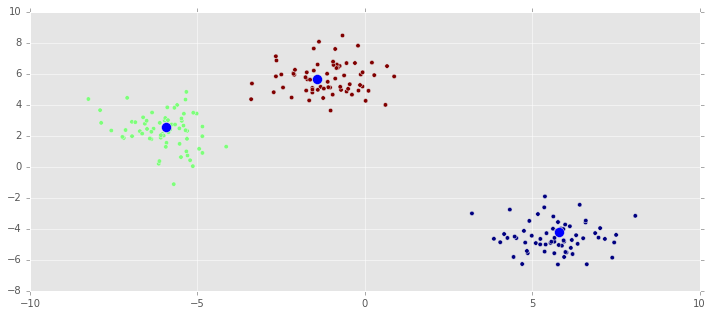

In [512]:
model = MiniBatchKMeans(k=3,  init='random', random_state=123, batch_size=50, max_iter=1000)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

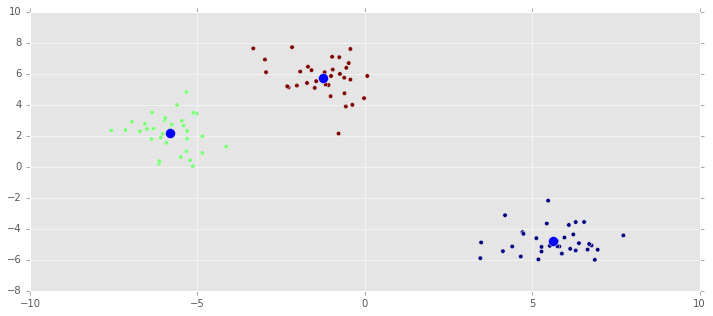

In [372]:
## Работоспособность KMeans

X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = KMeans(k=3,  init='random', random_state=123)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100)

# Почти всегда разбивает правильно на 3 кластера, 
# но иногда один из них разбит пополам, а два других объединены.
# Вероятно, это происходит, когда две случайно выбранные начальные координаты центров попадают в один кластер.

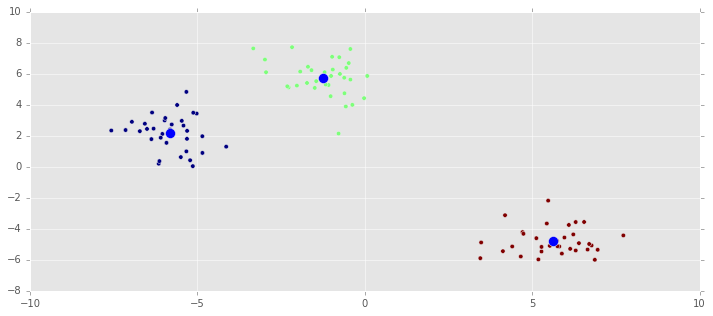

In [383]:
## Работоспособность KMeans++

X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = KMeans(k=3,  init='k-means')
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100)

# Почти всегда разбивает правильно на 3 кластера, 
# но иногда один из них разбит пополам, а два других объединены (вроде бы реже, чем при обычном k-means)
# Происходит это потому что выбор нового центроида тоже происходит случайно.

In [125]:
## Работоспособность KMeans с MiniBatchKMeans

In [12]:
## Работоспособность KMeans++ с MiniBatchKMeans

In [ ]:
## Время выполнения алгоритма KMeans

In [ ]:
## Время выполнения алгоритма KMeans++

In [ ]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans

In [ ]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [295]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()
df_sns.shape[0]

30000

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [ ]:
## KMeans

In [ ]:
## KMeans++

In [ ]:
## KMeans с MiniBatchKMeans

In [ ]:
## KMeans++ с MiniBatchKMeans

In [ ]:
## Вывод